# Protein LM Embeddings and Logits as Features

One of the best ways you can leverage a large language model is for feature generation. The internal, numeric representations the neural-net uses to make predictions can be output and used for downstream machine learning tasks. The numeric vectors from NLP models often encode additional, powerful information beyond simple one-hot encodings. Usually feature engineering for biology is heavily task-specific, but in this case the embeddings can be used for a variety of classification, regression, and other tasks.

On the backend, the process involves passing input sequences into the pre-trained model for tokenization and representation of the protein through its neural-net layers. Multiple representations of a protein - numeric vectors and/or matrices, such as attention maps - are created. Here we will quickly demo using ESM2 via GPU-backed REST API in order to quickly transform a sequence into embeddings without installing packages, setting up a GPU, and downloading the model.

In [1]:
TOKEN = " "  # YOUR TOKEN HERE!

In [ ]:
from helpers import api_caller  # We'll use this for asynchronous calling

In [2]:
# FOR IN-BROWSER JUPYTER-LITE ONLY #
import micropip  # Install with `pip install pandas` if running notebook elsewhere
await micropip.install('pandas')
await micropip.install('xgboost')
await micropip.install('scikit-learn')
await micropip.install('matplotlib')
await micropip.install('seaborn')

In [3]:
import os

import pandas as pd

from glob import glob

In [4]:
# Load sequences and fluorescence data
df = pd.concat([
    pd.read_csv(f) for f in
    glob(os.path.join('.', 'data', 'protein', 'data', 'fluor*.train.csv'))
])

df.drop_duplicates('seq', inplace=True)

In [5]:
df.shape

(21446, 2)

In [6]:
# SAMPLE some of the data
df_orig = df  # Retain original DF as `df_orig`
df = df_orig.copy().sample(50, random_state=42)

df.head(6)

,seq,label
19035,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,3.603359
20206,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATCGKLTLKFI...,3.940364
7499,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGVGDATYGKLTLKFI...,3.622829
1077,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.594085
18115,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.302041
4871,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.470378


Here we have a DataFrame containing sequences and their measured fluorescence. We can use the ESM2 embeddings as features to perform a quick regression to predict fluorescence values; but first we need to actually generate the embeddings.

Let's write a function that takes a sequence and requests its embeddings via REST API. The [ESM2 transform endpoint documentation](https://api.biolm.ai/#85ae0f23-0217-4498-8ccc-90a799eaee33) provides examples of the structure of a response.

In [7]:
SLUG = 'esm2_t33_650M_UR50D'

## Single Sequence Embeddings

In [8]:
test_protein = df.sample(1).seq.iloc[0]

print("Sequence length: {}\n{}".format(len(test_protein), test_protein))

Sequence length: 237
SKGEVLFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKDGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGTDELYK


We can POST that sequence:

In [9]:
# Definition comes from API reference docs linked just above
data = {
  "instances": [
    {
      "data": {
        "text": test_protein
      }
    }
  ]
}

# Async function to get embeddings via REST API
r = await api_caller(
    SLUG,
    'transform',
    data,
    TOKEN
)

In [10]:
from IPython.display import JSON

JSON(r)

<IPython.core.display.JSON object>

We get back a list of dicts. Each dictionary item `mean_representations` contains the mean representations of a layer(s) from ESM2. In this case, we return the embeddings from the the final hidden layer, `33`.

Let's load this representation and look at its shape.

In [11]:
embed_single = pd.DataFrame(r['predictions'][0]['mean_representations']['33']).T

embed_single

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.021863,-0.000873,-0.043651,-0.030389,-0.112526,-0.021947,-0.048023,0.022757,0.051771,-0.097739,...,0.170454,0.05533,-0.026595,0.080805,0.002878,0.093581,0.114525,0.03177,-0.02525,-0.014105


We can see that while the original sequence is `237` residues, the LLM uses a vector of `1280` to represent sequences. So, anytime we request an embedding for a sequence, we'll get back a representation that is the same size as another sequence. This makes downstream ML, especially with other NNs, nice and easy since we don't have to worry about padding.

Let's get the embeddings for all sequences in the DF, asynchronously, via REST API.

## Embeddings for All Seqs in DF

In [12]:
import asyncio
import random

# Limit concurrency to 3 requests at a time (*not* RPS)
sem = asyncio.Semaphore(5)


results = []

async def f(seq):
    # Add small jitter
    jitter = random.randint(1, 100) / 100.0  
    await asyncio.sleep(jitter * 4)
    # Definition comes from API reference docs linked just above
    data = {
      "instances": [
        {
          "data": {
            "text": seq
          }
        }
      ]
    }
    # Request the embeddings
    async with sem:
        r = await api_caller(
            SLUG,
            'transform',
            data,
            TOKEN
        )
        res = r['predictions'][0]['mean_representations']['33']
        
    return res


ops = [f(seq) for seq in df['seq'].to_list()]
rets = await asyncio.gather(*ops)

In [13]:
len(rets)

50

Now, instead of getting the embeddings, we could have written a function to retrieve the logits. In fact, they were returned by the same API endpoint - we simply need to use a different key. We can look at the single-sequence API request we made earlier to find them:

In [14]:
logits_single = pd.DataFrame(r['predictions'][0]['logits']).T

logits_single

,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
0,-5.452821,-5.702193,-5.774605,-5.751941,-5.825292,-5.834929,-5.749187,-5.76891,-5.740716,-5.808652,...,-5.516007,-5.945866,-5.497119,-5.89393,-5.778376,-5.861379,-5.761245,-5.650556,-5.462489,-5.532188


One could also use the sum or mean as a representation of sequence:

In [15]:
logits_single.iloc[0].sum()

-1381.7416291236877

In [16]:
logits_single.iloc[0].mean()

-5.830133456218092

## Modeling with XGBoost

In order to not require any transformations of the data, let's use a tree-based method to quickly create a regression model using these ESM2 embeddings.

We'll see how well we can model fluorescence with about 1,000 samples. With so few, we should make sure to uniformly sample our labels as much as possible.

This will take several minutes, depending on your download speed and connection bandwidth. We've added a slight jitter and limit of 5 concurrent connections above, to prevent thundering herds and overwhelming your connection. You can open your browser's Developer Tools (aka Inspector) and watch the traffic under the Network tab.

In [17]:
df_orig['bins'] = pd.cut(df_orig.label, bins=100)
df_orig['bins'] = df_orig['bins'].astype('str')

df_orig.bins.value_counts()

(1.281, 1.312]    1861
(3.669, 3.697]    1494
(3.612, 3.64]     1330
(3.697, 3.726]    1255
(3.64, 3.669]     1248
                  ... 
(2.448, 2.476]       2
(2.646, 2.675]       2
(2.05, 2.079]        2
(2.419, 2.448]       1
(4.066, 4.095]       1
Name: bins, Length: 97, dtype: int64

In [18]:
sampled = []

df_orig = df_orig.sample(df_orig.shape[0], random_state=42)

for n, grp in df_orig.groupby('bins'):
    # At most 15 rows from each bin
    samp = grp.head(10).reset_index(drop=True)
    sampled.append(samp)
    
sampled_rows = pd.concat(sampled, axis=0).reset_index(drop=True)

df_xgboost = sampled_rows

df_xgboost.shape

(810, 3)

In [19]:
ops = [f(seq) for seq in df_xgboost['seq'].to_list()]
xgboost_embeddings = await asyncio.gather(*ops)

In [20]:
embeddings = pd.DataFrame(xgboost_embeddings)

embeddings.shape

(810, 1280)

In [21]:
await micropip.install('seaborn')

In [22]:
from sklearn import model_selection

# Create 80:20 train:test split
train_x, test_x, train_y, test_y = model_selection.train_test_split(
    embeddings,
    df_xgboost.label,
    test_size=0.2,
    random_state=54
)

print("X Train size: {}\nX Test size: {}".format(train_x.shape, test_x.shape))
print("Y Train size: {}\nY Test size: {}".format(train_y.shape, test_y.shape))

X Train size: (648, 1280)
X Test size: (162, 1280)
Y Train size: (648,)
Y Test size: (162,)


In [23]:
embeddings.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.012797,-0.010230,-0.050427,-0.026590,-0.094134,-0.027904,-0.040282,0.011787,0.065593,-0.081904,...,0.162101,0.056518,-0.003955,0.084687,-0.015637,0.111645,0.089559,0.026398,-0.010537,-0.021326
1,-0.003391,0.000576,-0.045609,-0.005472,-0.106570,-0.005016,-0.033808,0.020165,0.052221,-0.083999,...,0.148607,0.067011,0.013806,0.086317,-0.018183,0.128099,0.092007,-0.003887,-0.015300,-0.026877
2,-0.001102,0.000435,-0.034191,-0.000218,-0.075750,-0.017704,-0.053314,0.008442,0.055483,-0.075902,...,0.130367,0.040951,0.002036,0.064880,-0.006501,0.093846,0.076521,0.015012,0.001324,-0.030217


In [24]:
import xgboost as xgb

#Set up cross-validation modeling objective
data_dmatrix = xgb.DMatrix(data=train_x, label=train_y)

params = {
    'booster': 'gbtree',
    "objective": "reg:squarederror",
    'colsample_bytree': 0.40,
    'learning_rate': 0.2,
    'max_depth': 40,
    'eval_metric': 'rmse',
    'alpha': 0.8,
}

# Run CV
cv_results = xgb.cv(
    dtrain=data_dmatrix,
    params=params,
    nfold=5,
    num_boost_round=100,
    early_stopping_rounds=6,
    metrics="rmse",
    as_pandas=True,
    seed=42
)

We can see how the performance of the model training started...

In [25]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.941635,0.008835,2.003446,0.047627
1,1.593452,0.006768,1.717158,0.050694
2,1.311360,0.005908,1.488701,0.053499
3,1.082645,0.004722,1.313581,0.047089
4,0.898073,0.003370,1.185266,0.051713


In [26]:
cv_results.tail(10)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
16,0.146004,0.001336,0.874557,0.055179
17,0.130258,0.001857,0.873675,0.055883
18,0.117884,0.002577,0.873233,0.055688
19,0.107436,0.002858,0.872333,0.055644
20,0.099296,0.001426,0.870233,0.055570
21,0.091355,0.000858,0.870148,0.055725
22,0.084062,0.001201,0.869700,0.056477
23,0.077806,0.002068,0.869309,0.056933
24,0.072138,0.001990,0.869065,0.057016
25,0.068007,0.002427,0.868767,0.057096


In [27]:
# Final RMSE on test set
print((cv_results["test-rmse-mean"]).tail(1))

25    0.868767
Name: test-rmse-mean, dtype: float64


In [28]:
# Final SD on test set
print((cv_results["test-rmse-std"]).tail(1))

25    0.057096
Name: test-rmse-std, dtype: float64


We can get context for these values by looking at the `Y` values that were used in this cross-validation experiment.

<AxesSubplot:>

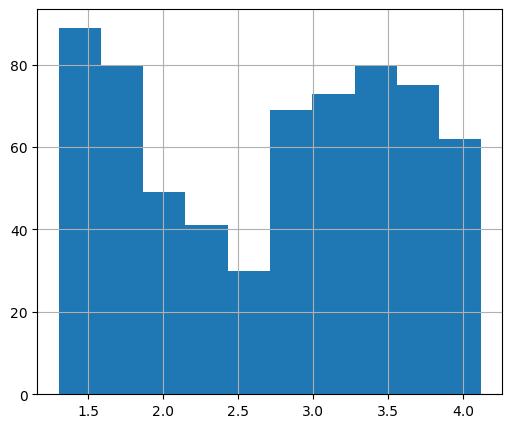

In [29]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6, 5))

train_y.hist()

Now we can train a model with the cross-validated parameters, using our full training dataset.

In [30]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=80)

Measuring the predicted values against our test set, let's see how well the model did using just the sequence embeddings features.

In [31]:
y_pred = xg_reg.predict(xgb.DMatrix(data=test_x, label=test_y))

<AxesSubplot:xlabel='label'>

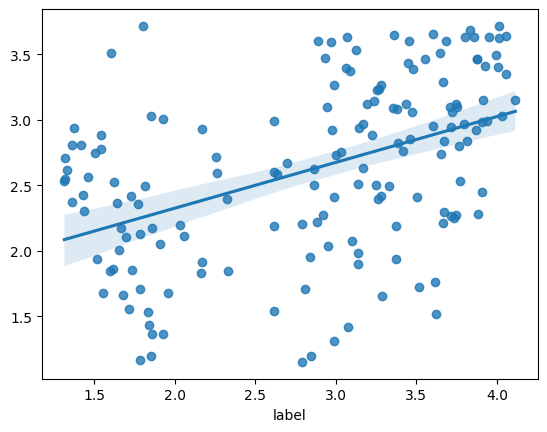

In [32]:
import seaborn as sns

sns.regplot(x=test_y, y=y_pred)

Lastly, we can attempt to inspect the model and learn a bit more about it, its fit, and our data.

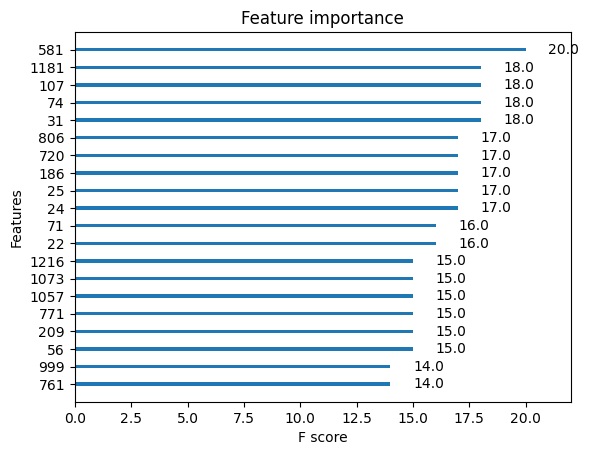

In [33]:
xgb.plot_importance(xg_reg, max_num_features=20, grid=False)
plt.rcParams['figure.figsize'] = [10, 8]
plt.show()